In [1]:
import sys, os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy
import gc

root = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(os.path.join(root,'imStat','code'))
import utils
import model_src
import other_model_code


In [2]:
import torch
# device = torch.device('cpu:0')
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce GTX TITAN X

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [3]:
# Loading a set of actual images

from scipy import io
import h5py

nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

# Loading images to do some more testing...
exp_design = io.loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()
print ('block size:', image_data.shape, ', dtype:', image_data.dtype, ', value range:',\
    np.min(image_data[0]), np.max(image_data[0]))

from utils import load_nsd

n_samples = 5000
trn_stim_data = load_nsd.image_uncolorize_fn(image_data)
trn_stim_data = trn_stim_data[ordering[0:n_samples]]

images = trn_stim_data

block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


In [4]:
# Parameters

from model_src import rf_grid

n_ori=8;
n_sf=3

cyc_per_stim = rf_grid.logspace(n_sf)(3., 72.)
# cyc_per_stim = rf_grid.logspace(n_sf)(20,72)

freqs_cpp = cyc_per_stim/227
# freqs_cpp = np.round(np.logspace(np.log10(0.02), np.log10(0.25), 3),2)
orient_step = 180/n_ori
orients_deg = np.arange(0,181-orient_step, orient_step)
spat_freq_bw = 1
spat_aspect_ratio = 1
n_sd_out = 4

process_at_size = [227,227]

In [13]:
## First level features (faster method that downsamples for low SFs)

def _to_torch(x, device=None):
    return torch.from_numpy(x).float().to(device)   

pix_per_cycle = 4.13   # this changes the actual size of filters in pixels, might help with orientation resolution?
# pix_per_cycle = 6

_gaborizer = Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=pix_per_cycle, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=False, pad_type='half', padding_mode='circular',
          crop=False).to(device)

# NOTE THIS MODEL HAS TWICE AS MANY FILTERS, TWO PER ORIENTATION (EVEN/ODD SYMMETRIC)
orient_filters = _gaborizer.orient_filters    
ft = _gaborizer.feature_table

maps_gab = _gaborizer(_to_torch(images[0:2],device=device))
maps_gab = [maps_gab[sf].detach().cpu().numpy() for sf in range(len(maps_gab))]

orients_deg = _gaborizer.orients_deg
phase_values = _gaborizer.phase_values

In [8]:
_gaborizer.orients_deg

array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])

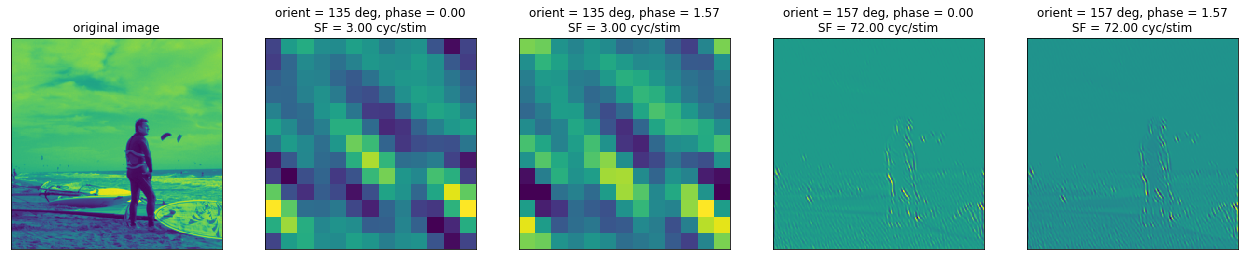

In [18]:
# Plotting first level feature maps

image_ind = 1

orient_ind_list = np.repeat(np.arange(n_ori), 2)
phase_ind_list = np.tile(np.arange(len(phase_values)), n_ori)

ori2plot = np.array([6,6,7,7]).astype('int')
sf2plot = np.array([0,0,2,2]).astype('int')
phase2plot = np.array([0,1,0,1]).astype('int')


plt.figure(figsize=(22,16));

plt.subplot(1,5,1)
plt.pcolormesh(images[image_ind,0,:,:])
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('original image')

for ii in  range(len(sf2plot)):
    
    xx = np.where(np.logical_and(orient_ind_list==ori2plot[ii], phase_ind_list==phase2plot[ii]))[0][0];
   
    plt.subplot(1,5,2+ii)
    plt.pcolormesh(maps_gab[sf2plot[ii]][image_ind,xx,:,:])

    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('orient = %d deg, phase = %.2f\nSF = %.2f cyc/stim'%(orients_deg[ori2plot[ii]],phase_values[phase2plot[ii]],cyc_per_stim[sf2plot[ii]]))
    plt.xticks([])
    plt.yticks([])
   

In [95]:
np.shape(maps_gab[2])

(2, 16, 298, 298)

In [83]:
uniq_filters_tst = _gaborizer.filter_stack_expanded[_gaborizer.feature_table['cycles per stimulus']==cyc_per_stim[0],:,:,:]

In [85]:
np.all(uniq_filters_tst == orient_filters)

True

In [88]:
_gaborizer.feature_table

,cycles per stimulus,pix per stimulus,orientation,cycles per filter,pix per filter,gauss. env. radius (pix),phase
0,3.000000,12,0.000000,2.8,12.0,2.891,0.000000
1,3.000000,12,0.000000,2.8,12.0,2.891,1.570796
2,3.000000,12,0.392699,2.8,12.0,2.891,0.000000
3,3.000000,12,0.392699,2.8,12.0,2.891,1.570796
4,3.000000,12,0.785398,2.8,12.0,2.891,0.000000
5,3.000000,12,0.785398,2.8,12.0,2.891,1.570796
6,3.000000,12,1.178097,2.8,12.0,2.891,0.000000
7,3.000000,12,1.178097,2.8,12.0,2.891,1.570796
8,3.000000,12,1.570796,2.8,12.0,2.891,0.000000
9,3.000000,12,1.570796,2.8,12.0,2.891,1.570796


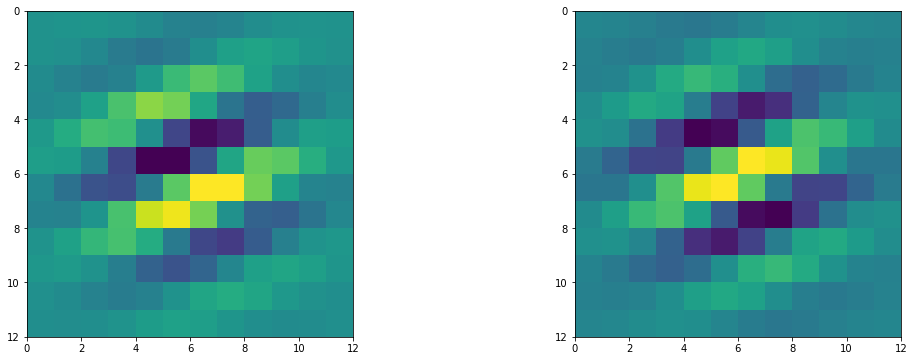

In [92]:
# Plot the simple cell filters just to check.
uniq_filters = _gaborizer.orient_filters
np.shape(uniq_filters)

plt.figure(figsize=(18,6));
plt.subplot(1,2,1)
plt.pcolormesh(uniq_filters[6,0,:,:])
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.pcolormesh(uniq_filters[7,0,:,:])
plt.axis('square')
plt.gca().invert_yaxis()


In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F


def make_2D_sinewave(freq, theta, phase, n_pix):
    '''
    freq is cycles/image
    theta is in radians
    phase is in radians (0 pi)
    center is (x,y) in pixel coordinates
    n_pix is size of the kernel in pixels
    '''
    vec = np.array([np.cos(theta), np.sin(theta)])*2*np.pi*freq / n_pix
    
    [Xm, Ym] = np.meshgrid(np.linspace(-.5*n_pix, .5*n_pix, n_pix), np.linspace(-.5*n_pix, .5*n_pix, n_pix))
    
    proj = np.array([Xm.ravel(), Ym.ravel()]).T.dot(vec)
    
    Dt = np.sin(proj+phase)              # compute proportion of Xm for given orientation
    Dt = Dt.reshape(Xm.shape)
    
    return Dt




def make_gaussian(center, sig, n_pix):
    """
    Make a picture of a circular gaussian blob.
    center is the center of the blob in pixels. center of image is (0,0)
    sig is one std. of the gaussian (pixels)
    n_pix is the size of the picture of the gaussian blob. i.e., output will be an 2D array that is n_pix-by-n_pix
    """
    
    [Xm, Ym] = np.meshgrid(np.linspace(-.5*n_pix, .5*n_pix, n_pix), np.linspace(-.5*n_pix, .5*n_pix, n_pix))
    
    x0 = center[0]
    y0 = center[1]
    
    Z = (1. / (2*np.pi*sig**2))
    
    return Z *np.exp(-((Xm-x0)**2 + (Ym-y0)**2) / (2*sig**2))




def make_gabor(freq, theta, phase, center, sig, n_pix):
    return make_2D_sinewave(freq, theta, phase, n_pix) * make_gaussian(center, sig,n_pix)




def make_complex_gabor(freq, theta, center, sig, n_pix):
    '''
    make_complex_gabor(freq, theta, center, sig, n_pix)
    freq is spatial frequency in cycles/image
    theta is orientation in radians
    center is (x,y) in pixel coordinates. center of image is (0,0)
    sig is one std of the gaussian envelope (pixels)
    n_pix is size of the kernel in pixels
    
    '''
    phase = 0
    on_gabor = make_gabor(freq, theta, phase, center, sig, n_pix)
    phase = np.pi/2.
    off_gabor = make_gabor(freq, theta, phase, center, sig, n_pix)
    
    return off_gabor + 1j*on_gabor




def make_feature_table(num_orientations, cycles_per_stim,
                     freq_spacing='log', pix_per_cycle=2, cycles_per_radius=1, 
                     radii_per_filter=4, complex_cell=True):
    '''
    Generates a table of parameters used to apply a gabor transform.
    This approach assumes that the gabors will be of fixed size (in pixels), but the image
    the gabors are applied to are downsampled, effectively determining the spatial frequency extracted 
    from the image.
    
    Returns everything needed to construct a stack of gabor filters. 
    
    feature_table, pix_per_filter, cyc_per_filter, envelope_radius_pix =
                                      make_feature_table((num_orientations, 
                                                          cycles_per_stim,
                                                          freq_spacing='log', 
                                                          pix_per_cycle=2, 
                                                          cycles_per_radius=1, 
                                                          radii_per_filter=4, 
                                                          complex_cell=True)
                     
    num_orientations  ~ number of linearly spaced orientations in [0,pi]
    cycles_per_stim   ~ either a tuple specifying range and number of spatial frequencies in cyc/stim 
                        (lowest, highest, num), or an explicit list of spatial frequencies (as np array or list)    
    freq_spacing      ~ log or linear. spacing of spatial frequencies. used only if cycles_per_stim is given as 
                        range. 
    pix_per_cycle     ~ how many pixels will be used to depict one cycle. default = 2, i.e., the Nyquist limit.
                        If too low, will result in jaggy edges or aliasing, but if too high, usually will require 
                        stimuli with larger than native resolution.
    cycles_per_radius ~ determines radius of gaussian envelop. we specify how many cycles the sinewave completes
                        per radius (1std.) of the gaussian envelope. default = 1 = one cycle of the sinewave per 
                        std. of the gaussian envelope.
    radii_per_filter  ~ determines the size of the filter. we specify how many radii (1std. each) of the gaussian
                        envelope fits inside of the filter. default = 4.
    complex_cell      ~ default = True, meaning that ea. feature map represents a given spatial frequency 
                        that is phase invariant (the absolute value is taken between a pair of feature maps 
                        constructed using filters with 0 and pi/2 phase). if False, we distinguish between 
                        filters with 0 and pi/2 phase, resulting in 2 feature maps for each spatial frequency.
    
    returns
    feature_table        ~ a pandas table with details of each feature to be extracted from images.
    pix_per_filter       ~ number of pixels per filter.  a constant.
    cyc_per_filter       ~ number of cycles per filter.  a constant.
    envelope_radius_pix  ~ number of pixels needed for one std. of the gaussian envelope. a constant.
            
    
    Note: depending on the size of your stimuli and the given parameters, you will be limited to a certain range 
    of spatial frequencies. If the lowest frequency is too low, the filter will be larger than the downsampled 
    image, which is kind of dumb. If the highest frequency is too high, the image will have to be upsampled to 
    obtain the required number of pixels per cycle, which is also dumb (not possible to capture a spatial 
    frequency that is higher than the original resolution of the image). The "full" range will have a lowest 
    frequency where the image is downsampled to the size of the filter, and a highest frequency where the image 
    is not downsampled at all. The larger the number of pixels per cycle, the smaller this range will be.
    
    '''
    
    oris = np.linspace(0, np.pi, num=num_orientations, endpoint=False) 
    
    ##------Sort out spatial frequencies to extract
    assert isinstance(cycles_per_stim, (tuple, list, np.ndarray)), 'cycles_per_stim must either be a tuple of len 3 (min, max, num), or an explicit list of spatial freqs (np array or list)' 
    
    ##if range of freqs given
    if type(cycles_per_stim) is tuple:       
        assert len(cycles_per_stim)==3, 'exactly 3 args required if cycles_per_stim is given as tuple (min, max, num)'
        if freq_spacing == 'log':
            cycles_per_stim = np.logspace(np.log10(cycles_per_stim[0]),np.log10(cycles_per_stim[1]),num=cycles_per_stim[2])
        elif freq_spacing == 'linear':
            cycles_per_stim = np.linspace(cycles_per_stim[0],cycles_per_stim[1],num=cycles_per_stim[2])
    
    #if explicit freqs given
    elif type(cycles_per_stim) is list:     
        cycles_per_stim = np.array(cycles_per_stim)
    elif type(cycles_per_stim) is np.ndarray: 
        pass

    
    ##------Inferred from your choices
    ##radius (1 std) of gaussian envelope of gabor filters in pixels
    envelope_radius_pix = pix_per_cycle * cycles_per_radius

    ##cycles per filter
    cycles_per_filter = cycles_per_radius * radii_per_filter ##should be constant
    
    ##given the num of cycles in a filter and the pix/cyc, this is how big the filter should be in pixels
    pix_per_filter = int(np.round(cycles_per_filter * pix_per_cycle)) ##should be constant
    
    ##given the num of cycles in a stim and the pix/cyc, this is how big the stim should be in pixels
    pix_per_stim = np.round(cycles_per_stim * pix_per_cycle).astype('int')
    

    ##------Construct pandas table of features 
    feature_table = pd.DataFrame([])

    
    # the order of these matches the order in full feature map - loops over sf at highest level, loops over orientation within each SF
    feature_table['cycles per stimulus'] = np.repeat(cycles_per_stim, num_orientations)
    feature_table['pix per stimulus']  = np.repeat(pix_per_stim, num_orientations)
    feature_table['orientation'] = np.tile(oris, len(cycles_per_stim))
    
    # these are constant
    feature_table['cycles per filter'] = cycles_per_filter*np.ones(np.shape(feature_table['orientation']))
    feature_table['pix per filter'] = pix_per_filter*np.ones(np.shape(feature_table['orientation']))
    feature_table['gauss. env. radius (pix)'] = envelope_radius_pix*np.ones(np.shape(feature_table['orientation']))
    
    if not complex_cell:
        # if simple cells, need to have twice as many orientation filters because considering odd/even parts separately.
        feature_table = feature_table.iloc[np.repeat(np.arange(len(feature_table)), 2)]        
        feature_table['phase'] = np.tile([0, np.pi/2.], len(cycles_per_stim)*num_orientations)
        feature_table.index = np.arange(len(feature_table.index))
#         other_feature_table = feature_table.copy()
#         other_feature_table['phase'] = np.pi/2.
#         feature_table = pd.concat([feature_table,other_feature_table],axis=0,ignore_index=True)

    
    return (feature_table,
            pix_per_filter,     
            cycles_per_filter,  
            envelope_radius_pix) 




def make_filter_stack(feature_table, pix_per_filter, cycles_per_filter, envelope_radius_pix, complex_cell=True, color_channels=1):
    
    ##initialize
    filter_stack = np.zeros((feature_table.shape[0],color_channels, pix_per_filter, pix_per_filter))
    if complex_cell:
        filter_stack = filter_stack+1j
    
    ##args to gaborme
    center = (0,0)
    freq = cycles_per_filter
    radius = np.float32(envelope_radius_pix)
    for ii,tx in enumerate(feature_table.index):
        ori = feature_table.loc[tx,'orientation'] 
        for c in range(color_channels):
            if complex_cell:
                filter_stack[ii,c,:,:] = make_complex_gabor(freq,ori,center,radius,pix_per_filter)
            else:
                ph = feature_table.loc[ii,'phase']
                filter_stack[ii,c,:,:] = make_gabor(freq,ori,ph,center,radius,pix_per_filter)
                
    return filter_stack




class Gaborizer(nn.Module):

    '''
    gaborizer = Gaborizer(num_orientations, 
                          cycles_per_stim,
                          freq_spacing='log', 
                          pix_per_cycle=2, 
                          cycles_per_radius=1, 
                          radii_per_filter=4, 
                          complex_cell=True, 
                          pad_type='half', 
                          crop=False)
                                          
    num_orientations  ~ number of linearly spaced orientations in [0,pi]
    cycles_per_stim   ~ either a tuple specifying range and number of spatial frequencies in cyc/stim 
                        (lowest, highest, num), or an explicit list of spatial frequencies (as np array or list)    
    freq_spacing      ~ log or linear. spacing of spatial frequencies. used only if cycles_per_stim is given as 
                        range. 
    pix_per_cycle     ~ how many pixels will be used to depict one cycle. default = 2, i.e., the Nyquist limit.
                        If too low, will result in jaggy edges or aliasing, but if too high, usually will require 
                        stimuli with larger than native resolution.
    cycles_per_radius ~ determines radius of gaussian envelop. we specify how many cycles the sinewave completes
                        per radius (1std.) of the gaussian envelope. default = 1 = one cycle of the sinewave per 
                        std. of the gaussian envelope.
    radii_per_filter  ~ determines the size of the filter. we specify how many radii (1std. each) of the gaussian
                        envelope fits inside of the filter. default = 4.
    complex_cell      ~ default = True, meaning that ea. feature map represents a given spatial frequency 
                        that is phase invariant (the absolute value is taken between a pair of feature maps 
                        constructed using filters with 0 and pi/2 phase). if False, we distinguish between 
                        filters with 0 and pi/2 phase, resulting in 2 feature maps for each spatial frequency.
    pad_type          ~ determines how much images will be padded before convolution.
                        can be either:
                        'half':  pad input with symmetric border that is filter width//2. if the filter width in 
                        pixels is odd, the convolution output will be the same width as the input. if even, the 
                        output width will be input width + 1. 
                        'full':  applies the filter wherever it partly overlaps with the stim. pads
                        input with symmetric border of filter width - 1. generates output that is 
                        input size + filter size - 1
    crop              ~ default = False. if True, the convolution output is cropped back down to the size of the 
                        resampled input stim. note that in most cases, this would mean part of the convolution 
                        was calculated for no reason. it is therefore recommended that pad_type 'half' is used if
                        feature maps that are close to the size of the input are desired. 
                        
    
    returns
    gaborizer         ~ a torch module that takes an image tensor [num stim, 1, pix, pix] and returns a list 
                        of tensors each representing feature maps of a different spatial frequency 
                        [num stim, num orientations, resampled stim pix, resampled stim pix]. 
                        
                        module parameters: 
                            real_filters_tnsr (Tensor):  [num orientations, 1, pix_per_filter, pix_per_filter] 
                            imag_filters_tnsr (Tensor):  [num orientations, 1, pix_per_filter, pix_per_filter];
                                                         if complex_cell = True
                                                         
                        instance variables include:
                            feature_table:               a pandas table with details of parameters that were set
                                                         to extract each feature 
                            filter_stack_expanded:       all filters (complex if complex_cell=True) used for convolution, 
                                                         repeated along axis=0 to match the complete stack of feature maps. 
                                                         [num oris * num of cyc_per_stim, 1, pix_per_filter, pix_per_filter]
    '''
    
    
    def __init__(self, num_orientations, cycles_per_stim,
                 freq_spacing='log', pix_per_cycle=2, cycles_per_radius=1, 
                 radii_per_filter=4, complex_cell=True, pad_type='half', padding_mode = 'circular',
                 crop=False):
     
        super(Gaborizer, self).__init__()
        
        self.num_orientations = num_orientations
        self.freq_spacing = freq_spacing
        self.pix_per_cycle = pix_per_cycle
        self.cycles_per_radius = cycles_per_radius
        self.radii_per_filter = radii_per_filter
        self.complex_cell = complex_cell
        self.pad_type = pad_type
        self.padding_mode = padding_mode
        self.crop=crop
        
        (self.feature_table,
         self.pix_per_filter,
         self.cycles_per_filter,
         self.envelope_radius_pix) = make_feature_table(num_orientations,
                                                        cycles_per_stim,
                                                        freq_spacing,
                                                        pix_per_cycle,
                                                        cycles_per_radius,
                                                        radii_per_filter,
                                                        complex_cell=self.complex_cell)
        
        self.filter_stack_expanded = make_filter_stack(self.feature_table,
                                                       self.pix_per_filter,
                                                       self.cycles_per_filter,
                                                       self.envelope_radius_pix,
                                                       complex_cell=self.complex_cell)
        

        #narrow filter stack down to only unique filters (should = num_orientations, or 2*num if these are simple cells w even and odd separate).        
        uniq_filters = self.filter_stack_expanded[self.feature_table['cycles per stimulus']==cycles_per_stim[0],:,:,:]
        self.orient_filters = uniq_filters
                                                        
        # Making tuning masks       
        self.sf_tuning_masks = []
        unique_sfs = np.unique(np.array(self.feature_table['cycles per stimulus']))
        assert(np.all(unique_sfs==cycles_per_stim))
        for sf_value in unique_sfs:
            self.sf_tuning_masks.append(np.array(self.feature_table['cycles per stimulus'])==sf_value)

        self.ori_tuning_masks = []
        unique_orients = np.unique(np.array(self.feature_table['orientation']))
        orients_deg = unique_orients/np.pi*180
        for ori_value in unique_orients:
            self.ori_tuning_masks.append(np.array(self.feature_table['orientation'])==ori_value)

        self.orients_deg = unique_orients/np.pi*180
        self.cyc_per_stim = unique_sfs         
    
        #split into real and imag gabor filters and represent ea. as tensor 
        if complex_cell:
            self.real_filters_tnsr = nn.Parameter(torch.tensor(np.real(uniq_filters), dtype=torch.float32, requires_grad=True))
            self.imag_filters_tnsr = nn.Parameter(torch.tensor(np.imag(uniq_filters), dtype=torch.float32, requires_grad=True))
        else:
            self.real_filters_tnsr = nn.Parameter(torch.tensor(uniq_filters, dtype=torch.float32, requires_grad=True))
            self.imag_filters_tnsr = None
            self.phase_values = np.unique(np.array(self.feature_table['phase']))
            
        #from table, get unique stim resolutions (corresponds to the diff. spatial frequencies being extracted)
        stim_sizes = self.feature_table['pix per stimulus'].unique()       
        
        self.lowest_freq = np.min(stim_sizes) 
        self.highest_freq = np.max(stim_sizes) 
        self.num_sp_freq = len(stim_sizes)
        
        #make a list of feature extractors, ea. extracting a diff freq (by resampling image to diff size before conv)
        self.gfe_list = []
        
        for new_dim in stim_sizes:
            
            #create instance of torch feature extractor with the given resampling parameter
            feature_extractor = GaborFeatExtractor(self.real_filters_tnsr, self.imag_filters_tnsr, 
                                                   (new_dim, new_dim), pad_type=self.pad_type, padding_mode=self.padding_mode, crop=self.crop)
            self.gfe_list.append(feature_extractor)
            
        
        
    def forward(self, minibatch_stim_tnsr):
        
        feature_map_list = []
        
        for n, gfe in enumerate(self.gfe_list):
            
            #for given freq, create feature map for each gabor orientation 
            sing_freq_features = gfe(minibatch_stim_tnsr)   #size [num stim, num orientations, stim pix, stim pix]
            
            #put each feature map tensor into a list of tensors 
            feature_map_list.append(sing_freq_features)

        return feature_map_list 




class GaborFeatExtractor(nn.Module):    
    def __init__(self, real_filters_tnsr, imag_filters_tnsr, new_dim, pad_type='half', padding_mode='circular', crop=False):
        super(GaborFeatExtractor, self).__init__()
        
        self.real_filters_tnsr = real_filters_tnsr
        self.imag_filters_tnsr = imag_filters_tnsr
        self.pad_type = pad_type
        self.padding_mode = padding_mode
        self.crop = crop
        
        #this will be the stimulus resampling function 
        self.resam = torch.nn.Upsample(new_dim, mode="bilinear", align_corners=True)
      
    def forward(self, minibatch_stim_tnsr):
        
        #resize stimuli
        resampled_stim_stack = self.resam(minibatch_stim_tnsr)
        input_sz = resampled_stim_stack.shape[2]
        
        #sort out stimulus padding
        assert self.pad_type in ['half', 'full'], 'pad_type must be either \'half\' or \'full\''
        if self.pad_type is 'half':
            pad_sz = self.real_filters_tnsr.shape[2]//2       #pad input w/ sym. border that is the floor the filter width/2
        else:
            pad_sz = self.real_filters_tnsr.shape[2] - 1      #apply filter wherever it partly overlaps with the input

       
#       real_feature_map_tnsr = F.conv2d(resampled_stim_stack, self.real_filters_tnsr, stride=1, padding=pad_sz) 

        nsamples = minibatch_stim_tnsr.shape[0]
        nfilters = self.real_filters_tnsr.shape[0]
        filter_size = self.real_filters_tnsr.shape[2]
        device = minibatch_stim_tnsr.get_device()
        
        #convolve stim with filters (returns feat maps of size [num stim, num orientations, stim pix, stim pix])
        # creating a conv2d layer here because it allows custom padding mode (want reflected mode because it minimizes edge artifacts compared to zero-padding)
        c = torch.nn.Conv2d(nsamples,nfilters, filter_size,stride=1, padding=pad_sz, padding_mode=self.padding_mode).to(device)
        c.weight.data = self.real_filters_tnsr
        c.bias.data.fill_(0)
        real_feature_map_tnsr = c(resampled_stim_stack)    
    
    
        #if was complex_cell, get imag feature map as well and square/sum real and imag parts
        if self.imag_filters_tnsr is not None:
            
#             imag_feature_map_tnsr = F.conv2d(resampled_stim_stack, self.imag_filters_tnsr, stride=1, padding=pad_sz)
            c = torch.nn.Conv2d(nsamples,nfilters, filter_size,stride=1, padding=pad_sz, padding_mode=self.padding_mode).to(device)
            c.weight.data = self.imag_filters_tnsr
            c.bias.data.fill_(0)
            imag_feature_map_tnsr = c(resampled_stim_stack)
            
            sngl_sf_featmap_tnsr = torch.sqrt((real_feature_map_tnsr**2)+(imag_feature_map_tnsr**2))
        else: 
            sngl_sf_featmap_tnsr = real_feature_map_tnsr
        
        #crop image back down to input size, if desired
        if self.crop: 
            crop_start = np.round((sngl_sf_featmap_tnsr.shape[2]-input_sz)/2).astype('int')
            crop_stop = crop_start + input_sz

            sngl_sf_featmap_tnsr = sngl_sf_featmap_tnsr[:, :, crop_start:crop_stop, crop_start:crop_stop]
            
        return sngl_sf_featmap_tnsr
 

class add_nonlinearity(nn.Module):
    def __init__(self, _fmaps_fn, _nonlinearity):
        super(add_nonlinearity, self).__init__()
        self.fmaps_fn = _fmaps_fn
        self.nl_fn = _nonlinearity
    def forward(self, _x):
        return [self.nl_fn(_fm) for _fm in self.fmaps_fn(_x)]
